<a href="https://colab.research.google.com/github/ananyascodehq/sales-forecasting-ml/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORT THE REQUIRED LIBRARIES**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**IMPORT THE DATASET**

In [10]:
import kagglehub
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'superstore-dataset-final' dataset.
Path to dataset files: /kaggle/input/superstore-dataset-final


In [7]:
import os
os.listdir(path)


['Sample - Superstore.csv']

In [11]:
df = pd.read_csv('/kaggle/input/superstore-dataset-final/Sample - Superstore.csv', encoding="ISO-8859-1", index_col='Row ID');

**EXPLORATORY DATA ANALYSIS**

In [12]:
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Row ID,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [13]:
df.describe()

,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,55190.379428,229.858001,3.789574,0.156203,28.656896
std,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,90008.000000,209.940000,5.000000,0.200000,29.364000
max,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 1 to 9994
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       9994 non-null   object 
 1   Order Date     9994 non-null   object 
 2   Ship Date      9994 non-null   object 
 3   Ship Mode      9994 non-null   object 
 4   Customer ID    9994 non-null   object 
 5   Customer Name  9994 non-null   object 
 6   Segment        9994 non-null   object 
 7   Country        9994 non-null   object 
 8   City           9994 non-null   object 
 9   State          9994 non-null   object 
 10  Postal Code    9994 non-null   int64  
 11  Region         9994 non-null   object 
 12  Product ID     9994 non-null   object 
 13  Category       9994 non-null   object 
 14  Sub-Category   9994 non-null   object 
 15  Product Name   9994 non-null   object 
 16  Sales          9994 non-null   float64
 17  Quantity       9994 non-null   int64  
 18  Discount     

**CONVERSION TO TIME-SERIES TABLE**

In [15]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [16]:
daily = df.groupby('Order Date').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'Order ID': 'nunique'
})
daily.rename(columns={'Order ID': 'num_orders'}, inplace=True)
daily.head()


,Sales,Quantity,num_orders
Order Date,,,
2014-01-03,16.448,2,1
2014-01-04,288.060,8,1
2014-01-05,19.536,3,1
2014-01-06,4407.100,30,3
2014-01-07,87.158,10,1


In [17]:
daily['day'] = daily.index.day
daily['month'] = daily.index.month
daily['year'] = daily.index.year
daily['dayofweek'] = daily.index.dayofweek
daily['is_weekend'] = daily['dayofweek'].isin([5,6]).astype(int)

daily['rolling_7'] = daily['Sales'].rolling(7).mean()
daily['rolling_30'] = daily['Sales'].rolling(30).mean()
daily['lag_1'] = daily['Sales'].shift(1)
daily['lag_7'] = daily['Sales'].shift(7)
daily['lag_30'] = daily['Sales'].shift(30)

In [18]:
daily.head()

,Sales,Quantity,num_orders,day,month,year,dayofweek,is_weekend,rolling_7,rolling_30,lag_1,lag_7,lag_30
Order Date,,,,,,,,,,,,,
2014-01-03,16.448,2,1,3,1,2014,4,0,NaN,NaN,NaN,NaN,NaN
2014-01-04,288.060,8,1,4,1,2014,5,1,NaN,NaN,16.448,NaN,NaN
2014-01-05,19.536,3,1,5,1,2014,6,1,NaN,NaN,288.060,NaN,NaN
2014-01-06,4407.100,30,3,6,1,2014,0,0,NaN,NaN,19.536,NaN,NaN
2014-01-07,87.158,10,1,7,1,2014,1,0,NaN,NaN,4407.100,NaN,NaN


In [19]:
daily.tail()

,Sales,Quantity,num_orders,day,month,year,dayofweek,is_weekend,rolling_7,rolling_30,lag_1,lag_7,lag_30
Order Date,,,,,,,,,,,,,
2017-12-26,814.5940,12,4,26,12,2017,1,0,3090.578286,3302.718267,2698.9270,1895.926,3666.157
2017-12-27,177.6360,6,1,27,12,2017,2,0,3061.992571,3140.367067,814.5940,377.736,5048.172
2017-12-28,1657.3508,64,10,28,12,2017,3,0,2992.908400,3141.670293,177.6360,2140.940,1618.254
2017-12-29,2915.5340,41,6,29,12,2017,4,0,2346.267400,3008.423293,1657.3508,7442.021,6912.944
2017-12-30,713.7900,23,4,30,12,2017,5,1,2172.983686,3015.820027,2915.5340,1926.776,491.888


In [ ]:
daily.info()

In [20]:
daily.isnull().sum()

,0
Sales,0
Quantity,0
num_orders,0
day,0
month,0
year,0
dayofweek,0
is_weekend,0
rolling_7,6
rolling_30,29


In [22]:
monthly = daily.resample('ME').agg({
    'Sales': 'sum',
    'Quantity': 'sum',
    'num_orders': 'sum'
})


In [23]:
monthly_avg = daily.groupby(['year', 'month'])['Sales'].mean().reset_index()
monthly_avg.columns = ['year', 'month', 'monthly_avg_sales']

In [24]:
daily = daily.reset_index().merge(
    monthly_avg,
    on=['year', 'month'],
    how='left'
)
daily = daily.set_index('Order Date')   # restore date index


In [25]:
daily.head()

,Sales,Quantity,num_orders,day,month,year,dayofweek,is_weekend,rolling_7,rolling_30,lag_1,lag_7,lag_30,monthly_avg_sales
Order Date,,,,,,,,,,,,,,
2014-02-12,129.568,2,1,12,2,2014,2,0,418.550857,594.361633,2043.400,211.646,16.448,86.588167
2014-02-14,576.726,10,2,14,2,2014,4,0,487.067143,603.983833,129.568,97.112,288.060,86.588167
2014-02-15,21.360,5,1,15,2,2014,5,1,470.920857,604.044633,576.726,134.384,19.536,86.588167
2014-02-16,9.040,5,1,16,2,2014,6,1,424.996286,457.442633,21.360,330.512,4407.100,86.588167
2014-02-17,54.208,14,1,17,2,2014,0,0,406.980286,456.344300,9.040,180.320,87.158,86.588167


In [26]:
import holidays
indian_holidays = holidays.India()
daily['is_holiday'] = daily.index.isin(indian_holidays).astype(int)

In [92]:
def get_season(m):
    # m is int month 1..12
    if m in (1, 2):
        return 'Winter'
    elif m in (3, 4, 5):
        return 'Summer'
    elif m in (6, 7, 8, 9):
        return 'Southwest Monsoon'
    else:  # 10,11,12
        return 'Retreating Monsoon'
daily['season'] = daily['month'].apply(get_season)

In [93]:
daily['season_code'] = daily['season'].astype('category').cat.codes
daily['is_winter'] = (daily['season'] == 'Winter').astype(int)
daily['is_summer'] = (daily['season'] == 'Summer').astype(int)
daily['is_monsoon'] = (daily['season'] == 'Southwest Monsoon').astype(int)
daily['is_retreating'] = (daily['season'] == 'Retreating Monsoon').astype(int)

In [94]:
daily['month_sin'] = np.sin(2 * np.pi * daily['month']/12)
daily['month_cos'] = np.cos(2 * np.pi * daily['month']/12)

In [95]:
daily['is_month_end'] = daily.index.is_month_end.astype(int)
daily['is_month_start'] = daily.index.is_month_start.astype(int)


In [96]:
daily['rolling_std_7'] = daily['Sales'].rolling(7).std()
daily['rolling_std_30'] = daily['Sales'].rolling(30).std()
daily = daily.drop(columns=['season', 'season_code'])
daily = daily.dropna()

In [97]:
daily.head()

,Sales,Quantity,num_orders,day,month,year,dayofweek,is_weekend,rolling_7,rolling_30,...,month_sin,month_cos,is_month_end,is_month_start,rolling_std_7,rolling_std_30,is_winter,is_summer,is_monsoon,is_retreating
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-05-31,773.700,6,1,31,5,2014,5,1,948.501857,848.862367,...,5.000000e-01,-0.866025,1,0,865.570050,927.440215,0,1,0,0
2014-06-01,5188.520,55,4,1,6,2014,6,1,1673.107571,996.184900,...,1.224647e-16,-1.000000,0,1,1737.097944,1219.374102,0,0,1,0
2014-06-02,738.598,16,2,2,6,2014,0,0,1761.544429,985.846833,...,1.224647e-16,-1.000000,0,0,1658.817049,1220.227586,0,0,1,0
2014-06-03,741.336,22,3,3,6,2014,1,0,1678.061286,993.687367,...,1.224647e-16,-1.000000,0,0,1698.633692,1217.792081,0,0,1,0
2014-06-04,456.272,12,2,4,6,2014,2,0,1435.043857,1006.475367,...,1.224647e-16,-1.000000,0,0,1739.815385,1209.774492,0,0,1,0


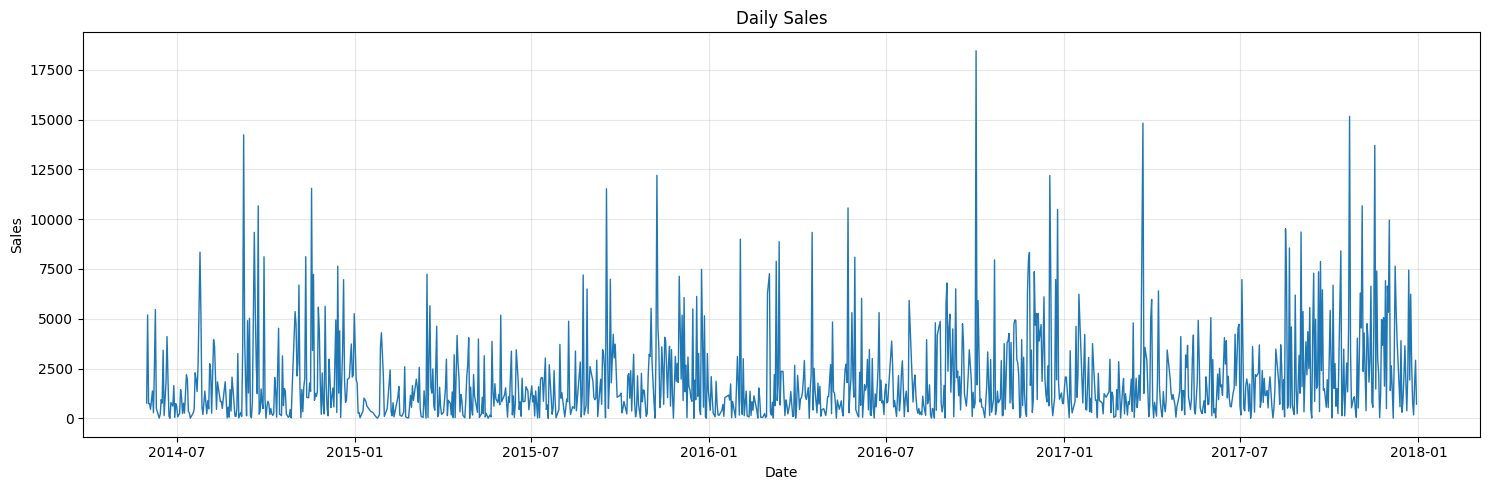

In [98]:
plt.figure(figsize=(15,5))
plt.plot(daily.index, daily['Sales'], linewidth=1)
plt.title("Daily Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [109]:
split_date = daily.index[int(len(daily) * 0.8)]
train = daily.loc[daily.index < split_date]
test  = daily.loc[daily.index >= split_date]

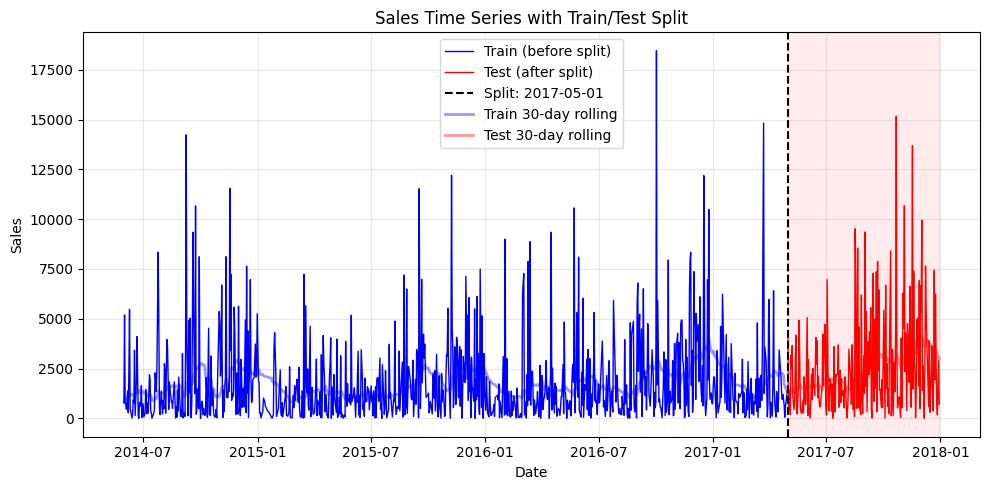

In [137]:

plt.figure(figsize=(10,5))
plt.plot(train.index, train['Sales'], color='blue', label='Train (before split)', linewidth=1)
plt.plot(test.index, test['Sales'], color='red', label='Test (after split)', linewidth=1)
plt.axvline(split_date, color='black', linestyle='--', linewidth=1.5, label=f"Split: {split_date.date()}")
plt.axvspan(test.index[0], test.index[-1], color='red', alpha=0.08)
plt.plot(train.index, train['rolling_30'], color='blue', alpha=0.4, linewidth=2, label='Train 30-day rolling')
plt.plot(test.index, test['rolling_30'], color='red', alpha=0.4, linewidth=2, label='Test 30-day rolling')

plt.title("Sales Time Series with Train/Test Split")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
X_train = train.drop(columns=['Sales'])
y_train = train['Sales']

X_test = test.drop(columns=['Sales'])
y_test = test['Sales']

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))
    )


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



In [103]:
from xgboost import XGBRegressor

'''xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror'
)

xgb.fit(X_train, y_train)'''

xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=1,
    reg_alpha=0.1,
    reg_lambda=1,
    objective='reg:squarederror'
)

xgb.fit(X_train, y_train_log)
log_pred = xgb.predict(X_test)
xgb_pred = np.expm1(log_pred)


In [104]:
mae_xgb = mean_absolute_error(y_test, xgb_pred)
rmse_xgb = rmse(y_test, xgb_pred)
mape_xgb = smape(y_test, xgb_pred)

print("XGBoost Performance:")
print("MAE :", mae_xgb)
print("RMSE:", rmse_xgb)
print("SMAPE:", mape_xgb, "%")

XGBoost Performance:
MAE : 1204.2116923276355
RMSE: 1930.9993870337119
SMAPE: 57.28389009668179 %


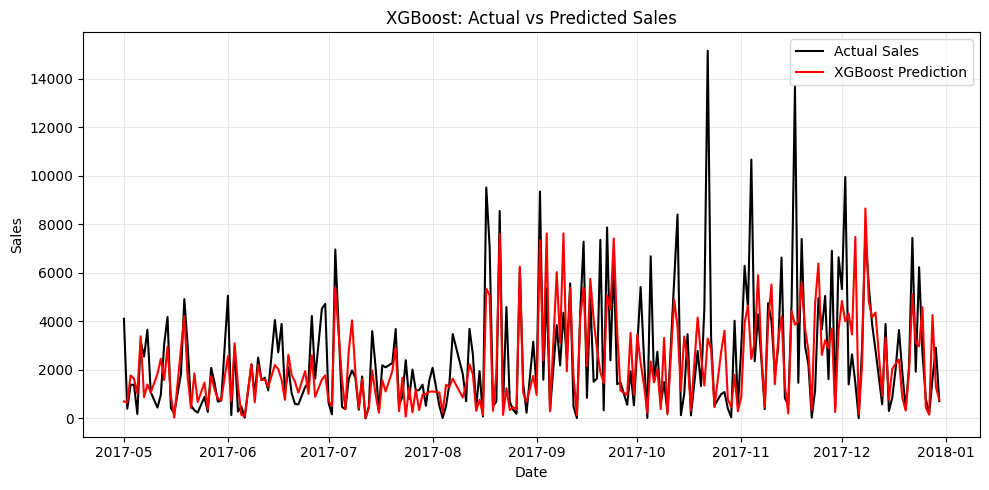

In [136]:
plt.figure(figsize=(10,5))

# Actual Test Sales
plt.plot(y_test.index, y_test.values, label="Actual Sales", color='black', linewidth=1.5)

# XGBoost Predictions
plt.plot(y_test.index, xgb_pred, label="XGBoost Prediction", color='red', linewidth=1.5)

plt.title("XGBoost: Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


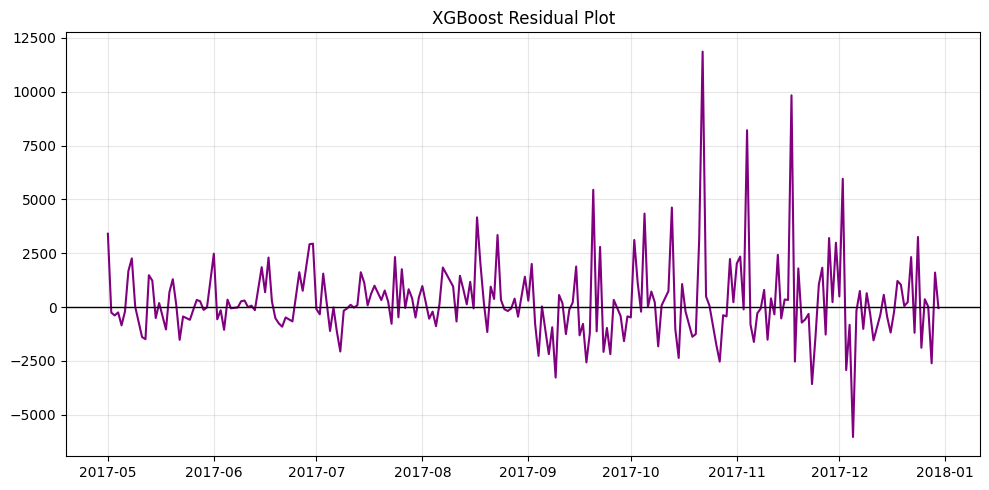

In [135]:
residuals = y_test - xgb_pred

plt.figure(figsize=(10,5))
plt.plot(residuals.index, residuals.values, color='purple')
plt.axhline(0, color='black', linewidth=1)
plt.title("XGBoost Residual Plot")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**FACEBOOK PROPHET**

In [111]:
prophet_df = daily[['Sales']].reset_index()
prophet_df.columns = ['ds', 'y']
prophet_train = prophet_df[prophet_df['ds'] < split_date]
prophet_test  = prophet_df[prophet_df['ds'] >= split_date]


In [113]:
from prophet import Prophet

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m.fit(prophet_train)


In [114]:
future = m.make_future_dataframe(periods=len(prophet_test))
forecast = m.predict(future)


In [115]:
prophet_pred = forecast[['ds', 'yhat']].tail(len(prophet_test))
prophet_pred = prophet_pred.set_index('ds')['yhat']


In [116]:
mae_prophet = mean_absolute_error(prophet_test['y'], prophet_pred)
rmse_prophet = np.sqrt(mean_squared_error(prophet_test['y'], prophet_pred))

In [122]:
smape_prophet = smape(prophet_test['y'].values, prophet_pred.values)

print("Prophet Performance:")
print("MAE :", mae_prophet)
print("RMSE:", rmse_prophet)
print("SMAPE:", smape_prophet)

Prophet Performance:
MAE : 1886.8358809684837
RMSE: 2628.682607684985
SMAPE: 83.57574183590948


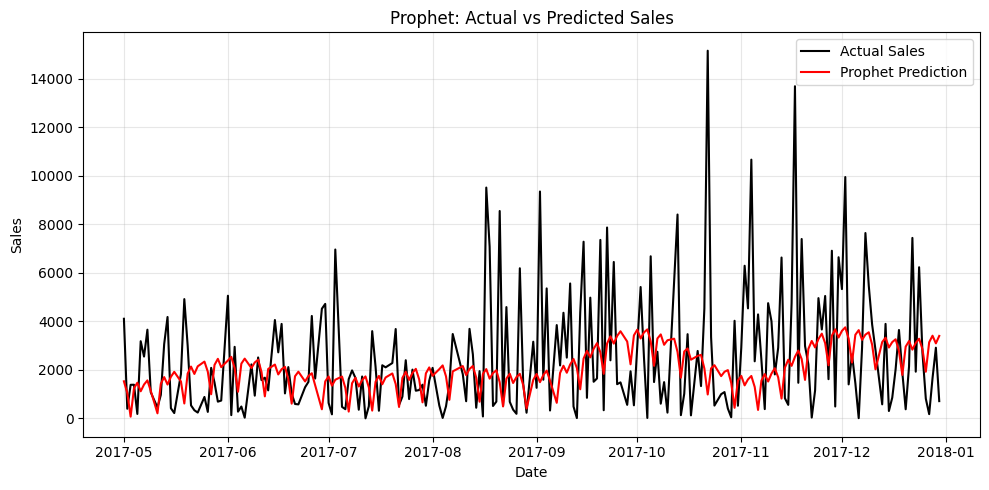

In [134]:
plt.figure(figsize=(10,5))

# Actual Test Sales
plt.plot(y_test.index, y_test.values, label="Actual Sales", color='black', linewidth=1.5)

# XGBoost Predictions
plt.plot(y_test.index, prophet_pred, label="Prophet Prediction", color='red', linewidth=1.5)

plt.title("Prophet: Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [132]:
hybrid_pred = 0.9 * xgb_pred + 0.1 * prophet_pred.values

In [133]:
smape(y_test.values, hybrid_pred)

np.float64(57.168563584704046)

In [140]:
prophet_pred_aligned = prophet_pred.reindex(y_test.index)

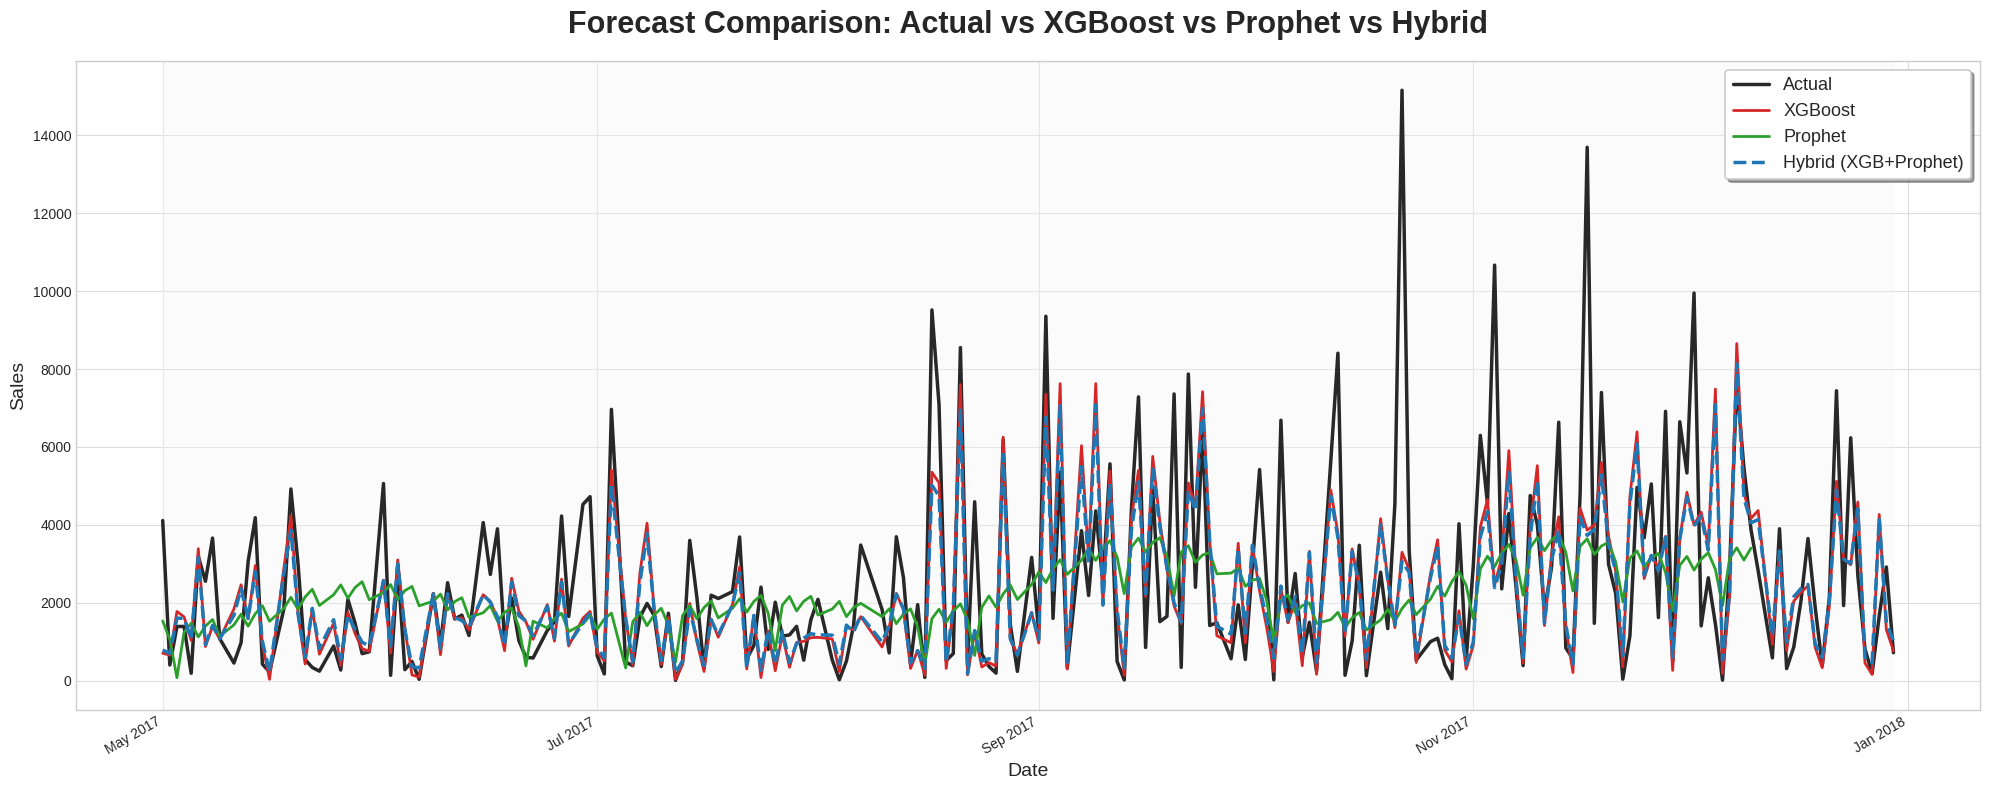

In [142]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(figsize=(20, 8))

# --- Line styling ---
ax.plot(y_test.index, y_test.values,
        label="Actual",
        color="#111111", linewidth=2.5, alpha=0.9)

ax.plot(y_test.index, xgb_pred,
        label="XGBoost",
        color="#D62728", linewidth=2)

ax.plot(y_test.index, prophet_pred_aligned.values,
        label="Prophet",
        color="#2CA02C", linewidth=2)

ax.plot(y_test.index, hybrid_pred,
        label="Hybrid (XGB+Prophet)",
        color="#1F77B4", linewidth=2.5, linestyle="--")

# --- Highlight region of test data ---
ax.axvspan(y_test.index[0], y_test.index[-1],
           color="#f5f5f5", alpha=0.35)

# --- Title formatting ---
ax.set_title("Forecast Comparison: Actual vs XGBoost vs Prophet vs Hybrid",
             fontsize=22, fontweight='bold', pad=20)

ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Sales", fontsize=14)

# --- Beautiful legend ---
legend = ax.legend(frameon=True, fancybox=True, shadow=True,
                   fontsize=13)
legend.get_frame().set_edgecolor('#cccccc')
legend.get_frame().set_linewidth(1.2)

# --- Clean ticks ---
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# --- Grid aesthetics ---
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linewidth=0.5)

plt.tight_layout()
plt.show()
